In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# define the transform to resize the images to 64x64 and convert them to tensors
transform = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])

# load the images from the folder img_align_celeba
dataset = ImageFolder('drive/MyDrive/celeba', transform=transform)

# print 5 of the images
for i in range(5):
    image, label = dataset[i]
    print(image.shape)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


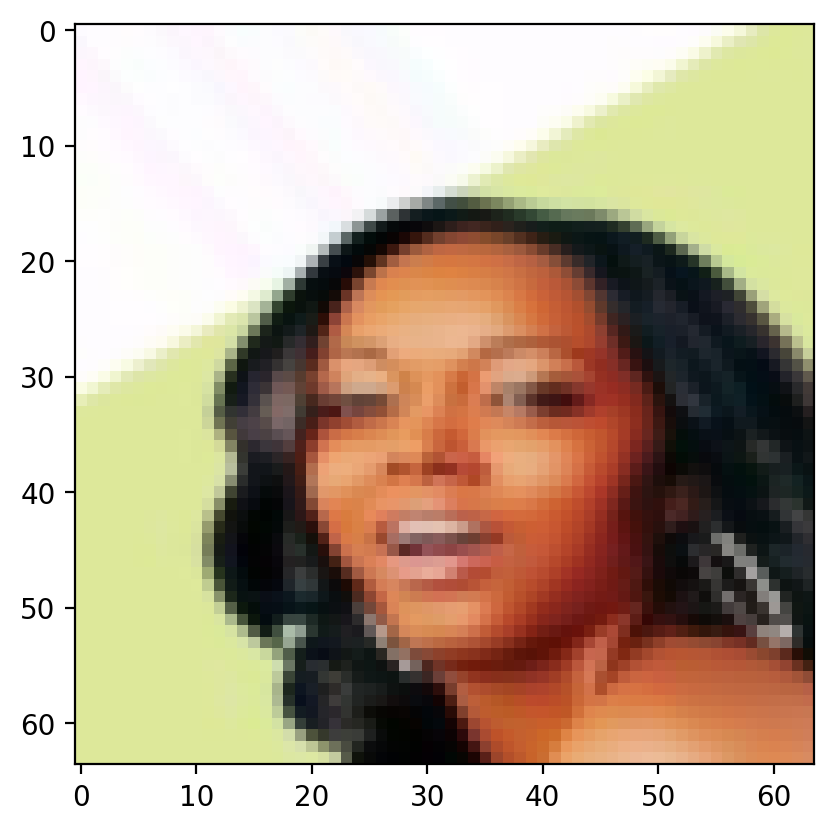

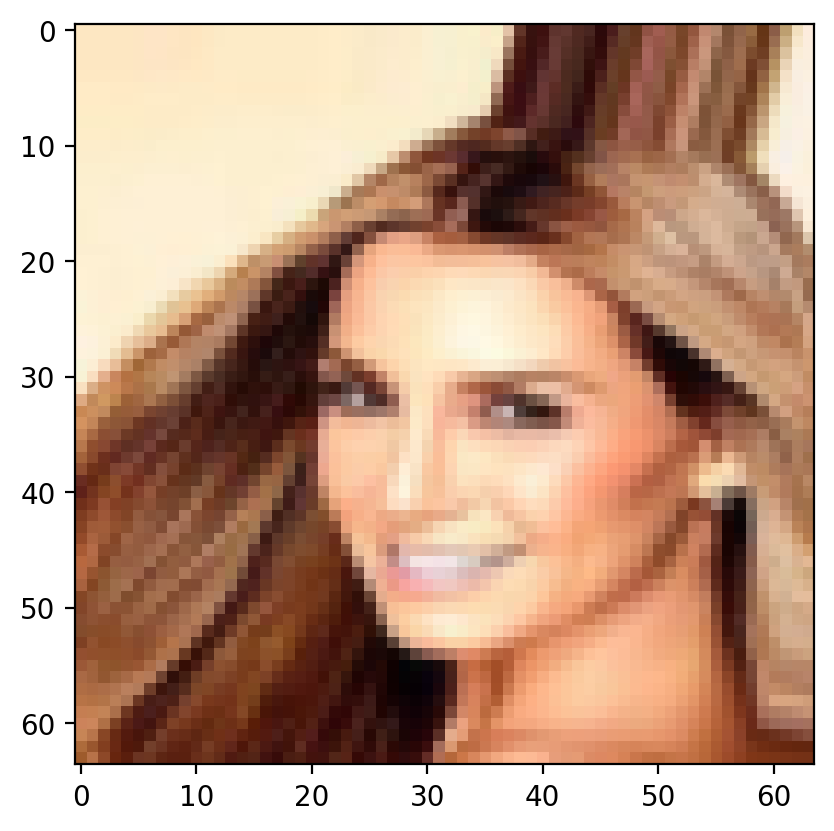

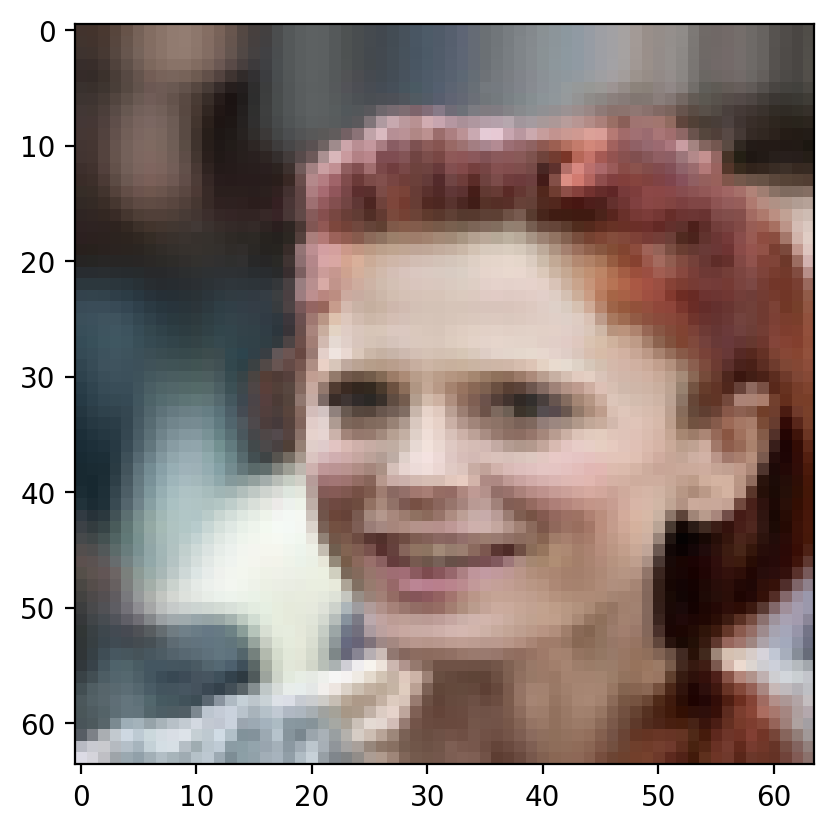

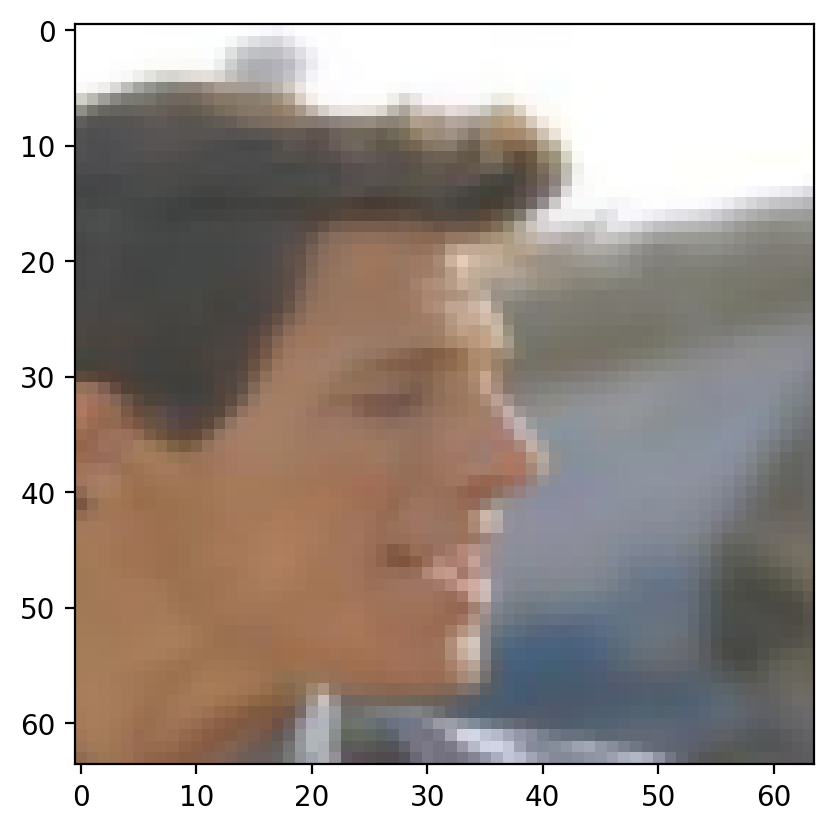

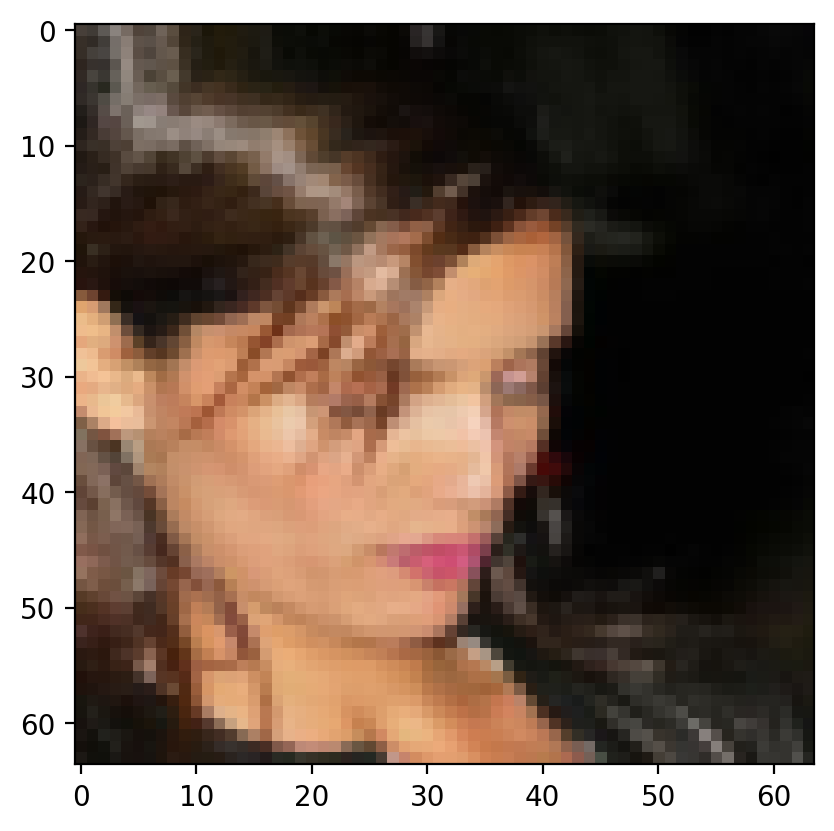

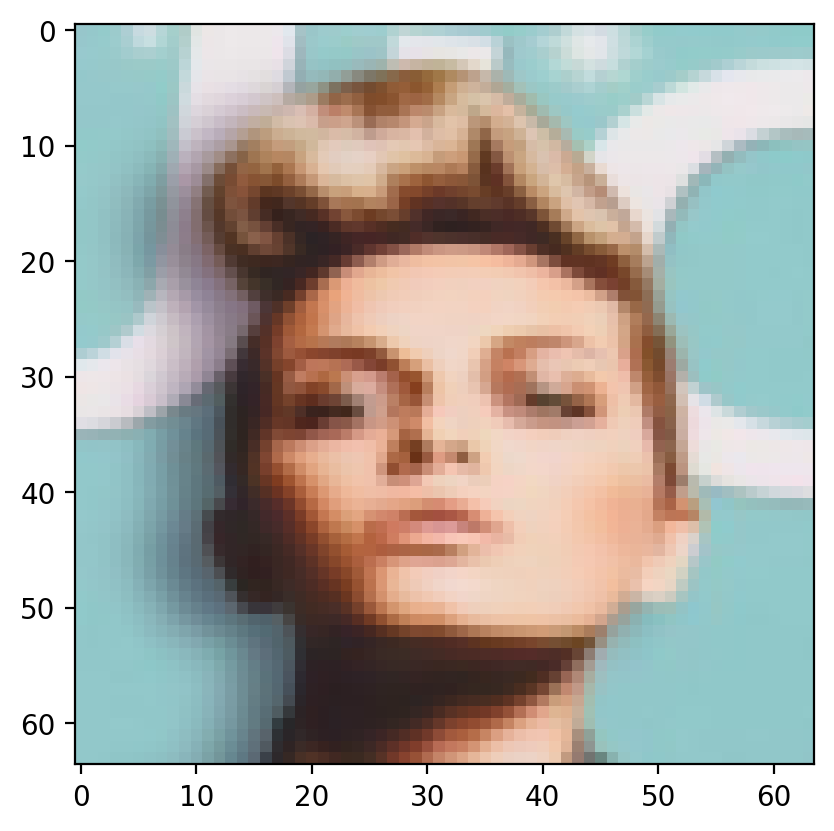

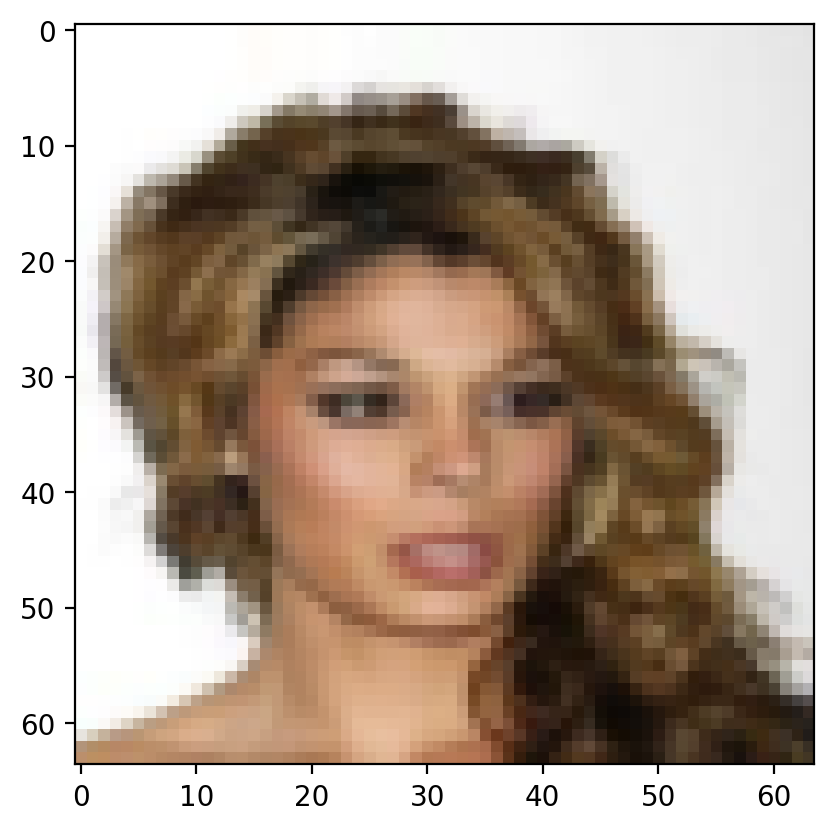

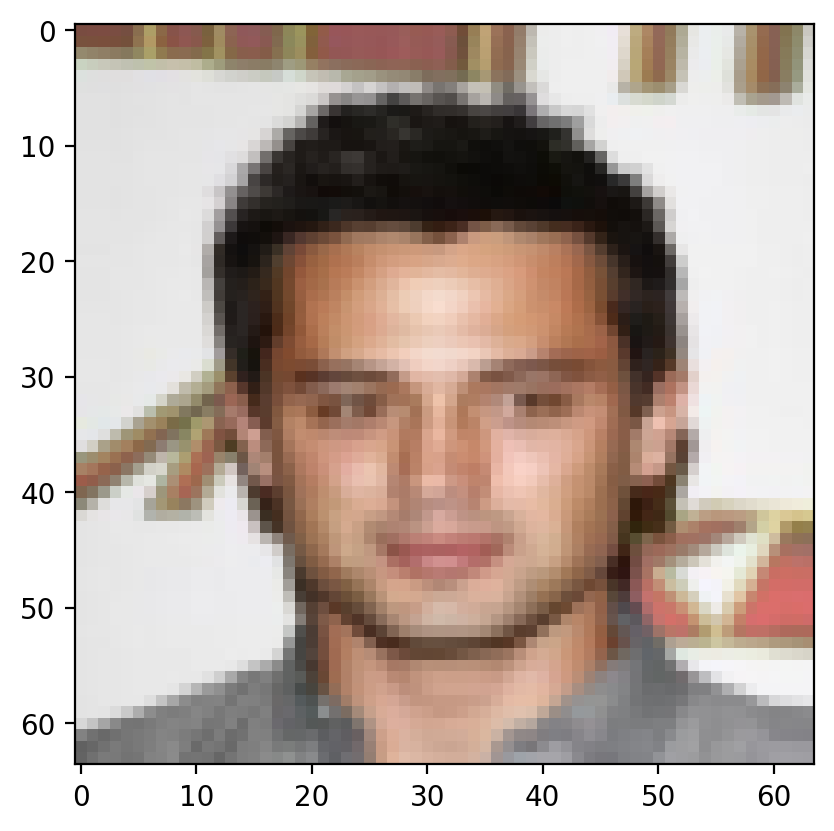

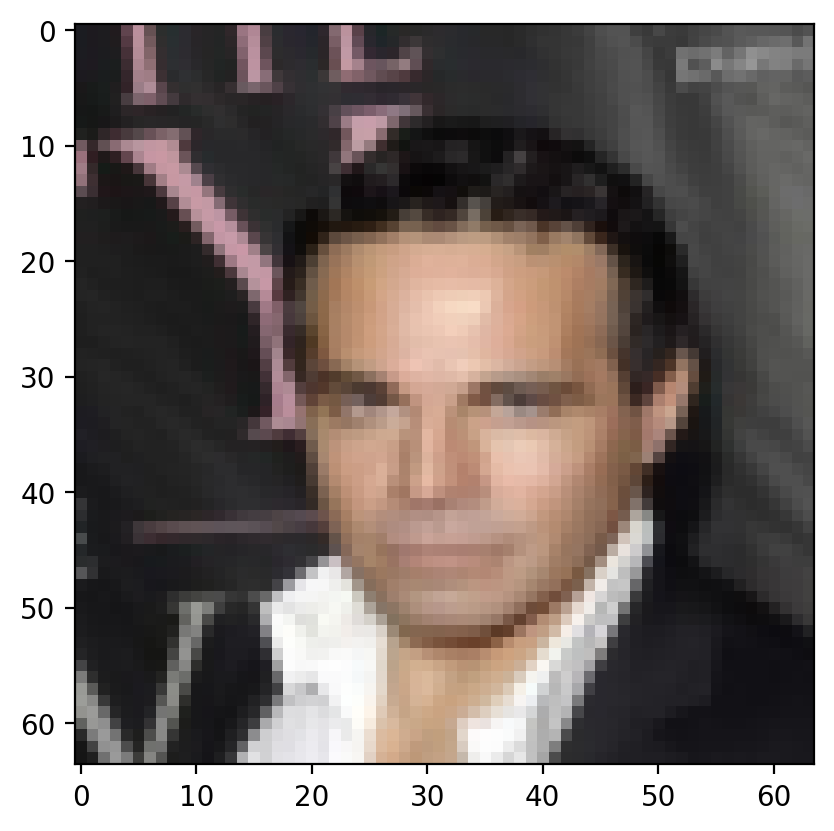

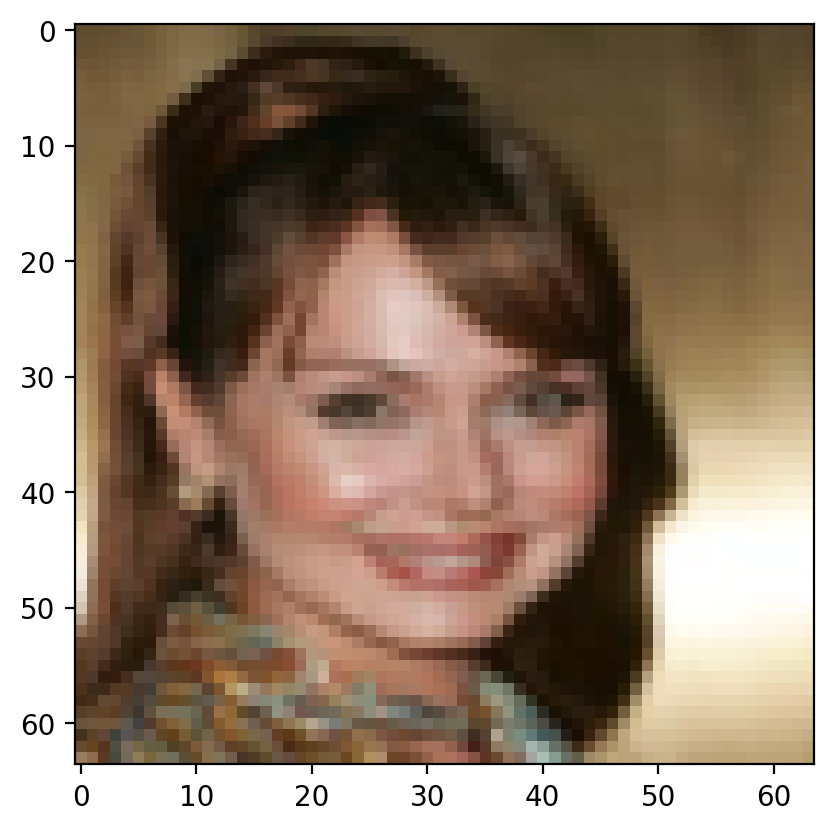

In [5]:
import matplotlib.pyplot as plt
for i in range(10):
  plt.imshow(dataset[i][0].permute(1,2,0))
  plt.show()

In [37]:
img0=dataset[2][0]

In [7]:
from sklearn import preprocessing
scaler_img=preprocessing.MinMaxScaler().fit(img.reshape(-1,1))

In [9]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [10]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.2640, 0.2680, 0.2920,  ..., 0.3200, 0.2960, 0.3200],
         [0.2600, 0.2640, 0.2880,  ..., 0.3200, 0.2960, 0.3240],
         [0.2480, 0.2520, 0.2840,  ..., 0.3160, 0.2960, 0.3280],
         ...,
         [0.3480, 0.5000, 0.6800,  ..., 0.5400, 0.5840, 0.6440],
         [0.7360, 0.8040, 0.8040,  ..., 0.4680, 0.5240, 0.5840],
         [0.8800, 0.8520, 0.7640,  ..., 0.4480, 0.5200, 0.5560]],

        [[0.2040, 0.2040, 0.2240,  ..., 0.3040, 0.2800, 0.3080],
         [0.2080, 0.2040, 0.2240,  ..., 0.3040, 0.2800, 0.3120],
         [0.2040, 0.2040, 0.2280,  ..., 0.3000, 0.2800, 0.3160],
         ...,
         [0.3720, 0.5160, 0.6960,  ..., 0.4040, 0.5040, 0.6120],
         [0.7440, 0.8080, 0.8080,  ..., 0.3080, 0.4000, 0.5120],
         [0.8760, 0.8480, 0.7640,  ..., 0.2680, 0.3640, 0.4520]],

        [[0.1800, 0.1760, 0.1920,  ..., 0.2920, 0.2680, 0.2880],
         [0.1840, 0.1800, 0.1960,  ..., 0.2920, 0.2680, 0.2920],
         [0.1880, 0.1840, 0.2040,  ..., 0.2880, 0.2680, 0.

In [11]:
img_scaled.shape

torch.Size([3, 64, 64])

In [34]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y

In [13]:
img_X,img_Y=create_coordinate_map(img_scaled)

In [14]:
img_Y.shape

torch.Size([4096, 3])

In [15]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [16]:
def transformed_images(img_raw):
    scaler_img=preprocessing.MinMaxScaler().fit(img_raw.reshape(-1,1))
    img_scaled = scaler_img.transform(img_raw.reshape(-1, 1)).reshape(img_raw.shape)
    img_scaled = torch.tensor(img_scaled)
    img_scaled = img_scaled.to(device)
    img_X,img_Y=create_coordinate_map(img_scaled)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())
    img_X_scaled = scaler_X.transform(img_X.cpu())
    img_X_scaled = torch.tensor(img_X_scaled).to(device)
    img_X_scaled = img_X_scaled.float()
    sh_index = torch.randperm(img_X_scaled.shape[0])

# Shuffle the dataset
    dog_X_sh = img_X_scaled[sh_index]
    dog_Y_sh = img_Y[sh_index]
    return dog_X_sh,dog_Y_sh

In [17]:
s = 64

class NN(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale,
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)

    def __init__(self, activation=torch.sin, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, 3) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        # x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)


In [18]:
from torchsummary import summary
newN=NN().to(device)
summary(newN,(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
            Linear-2                   [-1, 64]           4,160
            Linear-3                   [-1, 64]           4,160
            Linear-4                    [-1, 3]             195
Total params: 8,707
Trainable params: 8,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [19]:

# Shuffle data

# shuffled index
sh_index = torch.randperm(img_X_scaled.shape[0])

# Shuffle the dataset
dog_X_sh = img_X_scaled[sh_index]
dog_Y_sh = img_Y[sh_index]

In [20]:
dog_X_sh.shape

torch.Size([4096, 2])

In [21]:
nns = {}
nns["dog"] = {}
# nns["dog"]["relu"] = NN(activation=torch.relu, n_out=3).to(device)
nns["dog"]["sin"] = NN(activation=torch.sin, n_out=3, activation_scale=30.0).to(device)


In [22]:
n_iter = 2000

In [23]:


def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()



In [24]:
train(nns["dog"]["sin"], lr=3e-4, X=dog_X_sh, Y=dog_Y_sh, epochs=n_iter)

Epoch 0 loss: 0.293159
Epoch 100 loss: 0.010971
Epoch 200 loss: 0.004982
Epoch 300 loss: 0.003457
Epoch 400 loss: 0.002574
Epoch 500 loss: 0.001953
Epoch 600 loss: 0.001499
Epoch 700 loss: 0.001158
Epoch 800 loss: 0.000919
Epoch 900 loss: 0.000760
Epoch 1000 loss: 0.000650
Epoch 1100 loss: 0.000568
Epoch 1200 loss: 0.000510
Epoch 1300 loss: 0.000455
Epoch 1400 loss: 0.000409
Epoch 1500 loss: 0.000377
Epoch 1600 loss: 0.000345
Epoch 1700 loss: 0.000322
Epoch 1800 loss: 0.000305
Epoch 1900 loss: 0.000291


0.00027559418231248856

In [25]:


def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(num_channels, height, width)
        outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

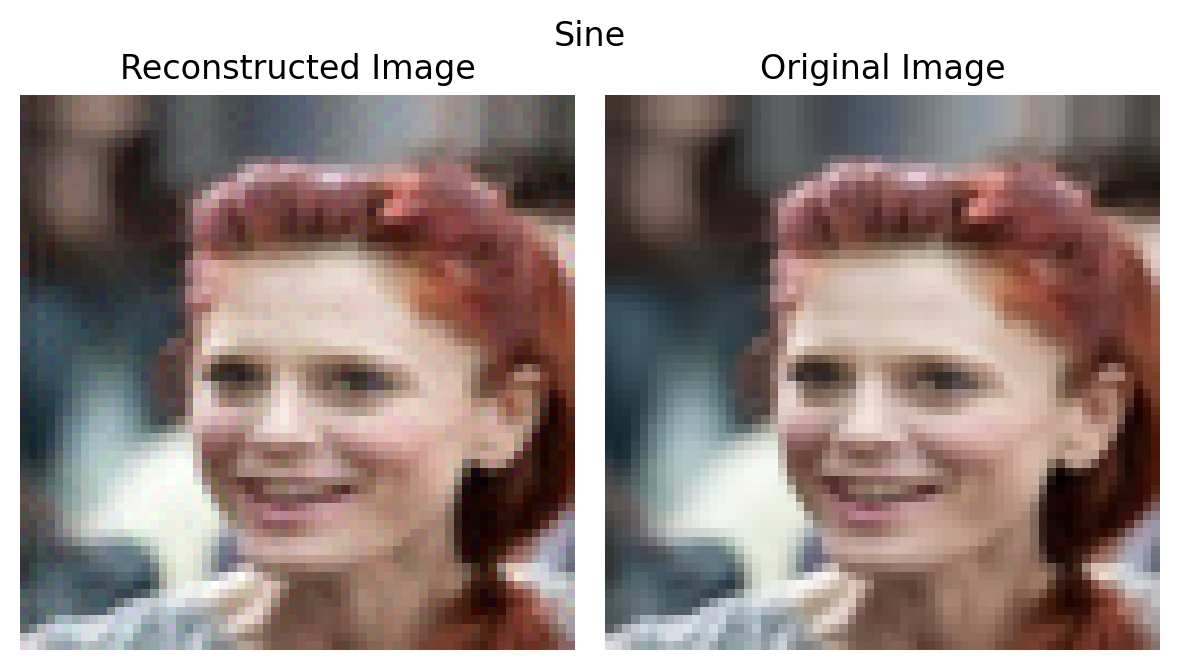

In [26]:
plot_reconstructed_and_original_image(img, nns["dog"]["sin"], img_X_scaled, title="Sine")

In [27]:
total_params=8707
ss=256
class HyperNet(nn.Module):
    def __init__(self, num_layers=5, num_neurons=256, activation=torch.sin, n_out=3):
        super().__init__()
        self.activation = activation
        self.n_out = total_params
        self.fc1 = nn.Linear(5, ss)
        self.fc2 = nn.Linear(ss, ss)
        self.fc3 = nn.Linear(ss, total_params)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [28]:
from torchsummary import summary
net=HyperNet().to(device)
summary(net,(5,))
# model2=TargetNet()
# model2.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           1,536
            Linear-2                  [-1, 256]          65,792
            Linear-3                 [-1, 8707]       2,237,699
Total params: 2,305,027
Trainable params: 2,305,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 8.79
Estimated Total Size (MB): 8.86
----------------------------------------------------------------


In [29]:
X_hyper=torch.cat((dog_X_sh,dog_Y_sh),dim=1)


In [ ]:
X_hyper.shape

torch.Size([4096, 5])

In [ ]:
params_out_1=net(X_hyper)

In [ ]:
params_out_1.shape

torch.Size([4096, 8707])

In [ ]:
params_mean=params_out_1.mean(dim=0)

In [ ]:
params_mean.shape

torch.Size([8707])

In [ ]:
target_net_2(dog_X_sh)

tensor([[ 1.3100, -0.6887, -0.6596],
        [ 0.8547,  0.2140, -0.1329],
        [ 0.9655, -1.1741,  0.4822],
        ...,
        [ 1.1943, -1.5160,  0.1881],
        [ 1.1752, -0.4365, -0.2045],
        [ 1.1249, -1.3329,  0.2759]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
dog_X_sh.shape

torch.Size([4096, 2])

In [31]:
from astra.torch.utils import ravel_pytree
from tqdm import tqdm
def train2(net1,net2,lr, context_X, context_Y,X,Y, epochs, verbose=True):
      X_hyper=torch.cat((context_X,context_Y),dim=1)
      criterion = nn.MSELoss()
      optimizer = torch.optim.Adam(net1.parameters(), lr=lr)
      for epoch in range(epochs):

        optimizer.zero_grad()
        params_out_1=net1(X_hyper)
        # print(params_out_1.shape)
        params_mean=params_out_1.mean(dim=0)
        flat_weights,unravel_fn= ravel_pytree(dict(net2.named_parameters()))
        parameter_diction=unravel_fn(params_mean)
        outputs = torch.func.functional_call(
        net2, parameter_diction, X
        )
        # outputs=net2(X)
        # outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
            # print(net2.)
      return loss.item()

In [ ]:
hyper_net_1=HyperNet(activation=nn.ReLU()).to(device)
target_net_1=NN(activation=nn.ReLU()).to(device)
for i in tqdm(range(5)):
  imagee=dataset[i][0]
  ab,ba=transformed_images(imagee)
  train2(hyper_net_1,target_net_1, lr=3e-4,context_X=ab[::5],context_Y=ba[::5], X=ab, Y=ba, epochs=8000,verbose=False)

100%|██████████| 5/5 [05:08<00:00, 61.62s/it]


In [ ]:
train2(hyper_net_1,target_net_1, lr=3e-4,context_X=dog_X_sh[::3],context_Y=dog_Y_sh, X=dog_X_sh, Y=dog_Y_sh, epochs=10000)

Epoch 0 loss: 0.005748
Epoch 100 loss: 0.007852
Epoch 200 loss: 0.007095
Epoch 300 loss: 0.006150
Epoch 400 loss: 0.006510
Epoch 500 loss: 0.006006
Epoch 600 loss: 0.005802
Epoch 700 loss: 0.005991
Epoch 800 loss: 0.005864
Epoch 900 loss: 0.005881
Epoch 1000 loss: 0.005630
Epoch 1100 loss: 0.005808
Epoch 1200 loss: 0.005553
Epoch 1300 loss: 0.005563
Epoch 1400 loss: 0.005593
Epoch 1500 loss: 0.005993
Epoch 1600 loss: 0.005441
Epoch 1700 loss: 0.005439
Epoch 1800 loss: 0.005355
Epoch 1900 loss: 0.005290
Epoch 2000 loss: 0.005547
Epoch 2100 loss: 0.005343
Epoch 2200 loss: 0.005243
Epoch 2300 loss: 0.005803
Epoch 2400 loss: 0.005426
Epoch 2500 loss: 0.005143
Epoch 2600 loss: 0.005144
Epoch 2700 loss: 0.005374
Epoch 2800 loss: 0.005141
Epoch 2900 loss: 0.005058
Epoch 3000 loss: 0.005021
Epoch 3100 loss: 0.005210
Epoch 3200 loss: 0.005278
Epoch 3300 loss: 0.005656
Epoch 3400 loss: 0.005244
Epoch 3500 loss: 0.005037
Epoch 3600 loss: 0.005012
Epoch 3700 loss: 0.005028
Epoch 3800 loss: 0.00533

0.004219450056552887

In [ ]:
def plot_reconstructed_and_original_image_2(original_img, net1,net2,X, context_X,context_y, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    X_hyper=torch.cat((context_X,context_y),dim=1)
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        # outputs = net1(X_hyper)
        params_out_1=net1(X_hyper)
        # print(params_out_1.shape)
        params_mean=params_out_1.mean(dim=0)
        flat_weights,unravel_fn= ravel_pytree(dict(net2.named_parameters()))
        parameter_diction=unravel_fn(params_mean)
        outputs = torch.func.functional_call(
        net2, parameter_diction, X
        )
        outputs = outputs.reshape(num_channels, height, width)
        outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

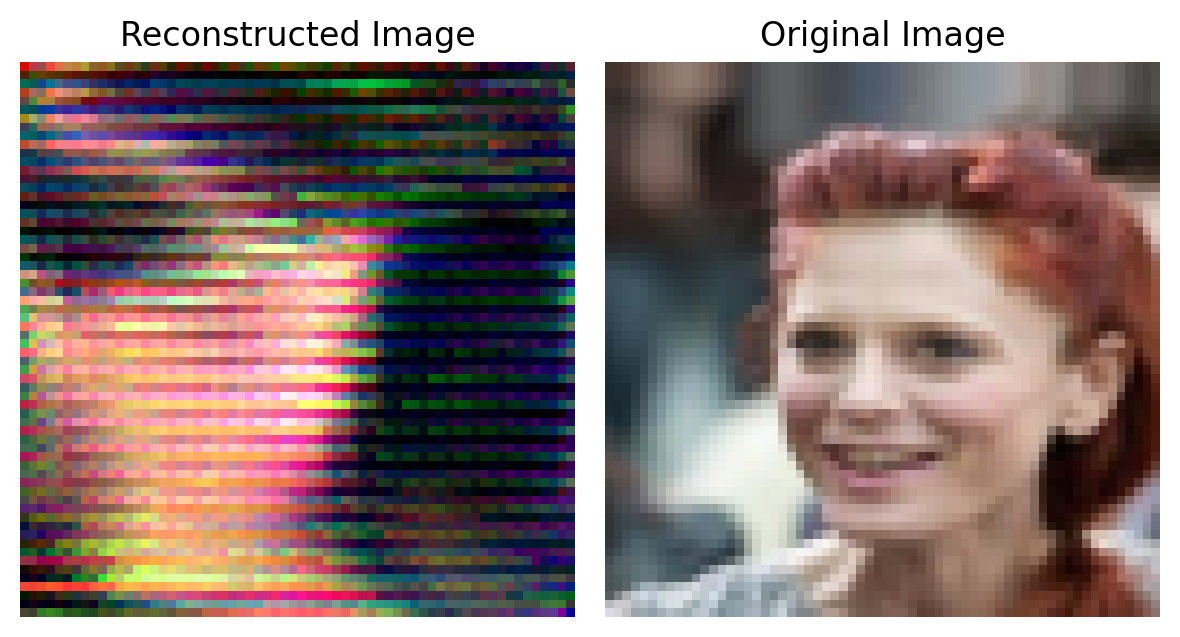

In [ ]:
plot_reconstructed_and_original_image_2(img,hyper_net_1, target_net_1, img_X_scaled,img_X_scaled,img_Y)

In [ ]:
  !pip install git+https://github.com/sustainability-lab/ASTRA

  Cloning https://github.com/sustainability-lab/ASTRA to /tmp/pip-req-build-4oicgooi
  Running command git clone --filter=blob:none --quiet https://github.com/sustainability-lab/ASTRA /tmp/pip-req-build-4oicgooi
  Resolved https://github.com/sustainability-lab/ASTRA to commit 23345df2f1b9900ac6303b1bb626711b71e58504
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 6.8 MB/s eta 0:00:00
  Created wheel for astra-lib: filename=astra_lib-0.0.3.dev3+g23345df-py3-none-any.whl size=22090 sha256=6170df240cccf2d55826cad5ea43b2656e48f2d5a680d80845bc77a7e3a921a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnrskuwy/wheels/d2/15/2e/f13066a6ef01e7aae774005c8cf7717fb3bdac65a5c3c928a1
Successfully built astra-lib


In [ ]:
from astra.torch.utils import ravel_pytree
flat_weights,unravel_fn= ravel_pytree(dict(nns["dog"]["sin"].named_parameters()))
print(flat_weights.shape)
print(unravel_fn(flat_weights))

torch.Size([8707])
{'fc1.weight': tensor([[-0.0408,  0.3172],
        [-0.3766, -0.2711],
        [-0.0848, -0.2852],
        [ 0.2540, -0.5027],
        [ 0.1741,  0.0081],
        [-0.4092,  0.1003],
        [-0.0855,  0.3557],
        [-0.4011, -0.4669],
        [ 0.2188, -0.3942],
        [ 0.2468,  0.4651],
        [ 0.0026, -0.4610],
        [-0.1460, -0.3343],
        [ 0.2071, -0.1103],
        [-0.0193, -0.4210],
        [ 0.4976, -0.4621],
        [-0.4242, -0.3532],
        [ 0.0098,  0.0358],
        [-0.0048,  0.3270],
        [ 0.1423,  0.1289],
        [ 0.4539, -0.5178],
        [-0.4449,  0.3415],
        [ 0.2426,  0.3939],
        [-0.4540, -0.1631],
        [-0.2913,  0.4420],
        [ 0.2680, -0.4008],
        [-0.4765, -0.3836],
        [-0.3703, -0.2346],
        [-0.3113,  0.4020],
        [ 0.3004, -0.0233],
        [ 0.2972,  0.3116],
        [ 0.1298, -0.5049],
        [ 0.1339,  0.1874],
        [-0.1509, -0.4741],
        [ 0.0617,  0.4698],
        [ 0.37

In [ ]:
print(target_net_1.named_parameters)

<bound method Module.named_parameters of NN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)>


In [ ]:
for name, param in target_net_1.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value:\n{param.data}")

Parameter name: fc1.weight
Parameter value:
tensor([[ 0.1390, -0.1608],
        [-0.1537, -0.0530],
        [-0.0067,  0.0359],
        [ 0.0205, -0.0574],
        [-0.0233,  0.1647],
        [ 0.1433, -0.1186],
        [ 0.1811,  0.2008],
        [ 0.0544, -0.0308],
        [-0.3059, -0.1488],
        [-0.1251,  0.1367],
        [ 0.1401, -0.0018],
        [-0.1478, -0.0885],
        [ 0.2015,  0.2203],
        [ 0.1064,  0.0772],
        [ 0.0204, -0.0089],
        [ 0.0212,  0.0608],
        [-0.0714, -0.1017],
        [ 0.0944, -0.0676],
        [-0.1171, -0.0712],
        [-0.0367, -0.1647],
        [ 0.0548, -0.1135],
        [-0.0868, -0.0127],
        [-0.1212, -0.2676],
        [ 0.0765, -0.0060],
        [ 0.0925,  0.2037],
        [ 0.0569,  0.0381],
        [-0.0452,  0.0367],
        [-0.0789, -0.2220],
        [ 0.0398, -0.0125],
        [-0.1219,  0.0706],
        [-0.1302, -0.0719],
        [ 0.1258, -0.0439],
        [ 0.0560, -0.2454],
        [-0.0268,  0.1017],
    

In [ ]:
params=hyper_net_1(X_hyper).mean(dim=0)

In [ ]:
params

tensor([ 0.1390, -0.1608, -0.1537,  ..., -0.1130,  0.0226, -0.0180],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [ ]:
from astra.torch.utils import ravel_pytree
flat_weights, unravel_fn = ravel_pytree(dict(target_net_1.named_parameters()))
# param_dic=unravel_fn(params)
# opp = torch.func.functional_call(
#         target_net_1, param_dic, X
#     )

In [ ]:
flat_weights.shape

torch.Size([8577])

In [124]:
h=512
r=512
z=512
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc1=nn.Linear(2+z,h)
    self.fc2=nn.Linear(h,h)
    self.fc3=nn.Linear(h,h)
    self.fc4=nn.Linear(h,3)
    self.fc5=nn.Linear(h,3)
  def forward(self,x,z):
    points,_=x.size()
    # print(points,z.shape)
    z=z.repeat(points,1)
    # print(points,z.shape)
    input=torch.cat((x,z),dim=1)
    # print(input.shape)
    hidden=self.fc1(input)
    hidden=torch.sin(hidden)
    hidden=self.fc2(hidden)
    hidden=torch.sin(hidden)
    hidden=self.fc3(hidden)
    hidden=torch.sin(hidden)
    mu=self.fc4(hidden)
    sig=0.1+0.9*F.softplus(self.fc5(hidden))
    return mu,sig


class CNP(nn.Module):
  def __init__(self):
    super(CNP, self).__init__()
    self.decode=Decoder().to(device)
    self.fc1=nn.Linear(5,h)
    self.fc2=nn.Linear(h,h)
    self.fc3=nn.Linear(h,r)
    self.fc4=nn.Linear(r,r)
    self.fc5=nn.Linear(r,z)
    self.fc6=nn.Linear(r,z)

  def xy_mu_sigma(self,x,y):
    input_p=torch.cat((x,y),dim=1)
    x=self.fc1(input_p)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.fc3(x)
    x=torch.mean(x,dim=0)
    x=self.fc4(x)
    x=F.relu(x)
    mu=self.fc5(x)
    sigma=0.1+0.9*torch.sigmoid(self.fc6(x))
    return mu,sigma
  def forward(self,x_c,y_c,x,y=None):
    if self.training:
      mu1,sig1=self.xy_mu_sigma(x,y)
      muc,sigc=self.xy_mu_sigma(x_c,y_c)
      qt=torch.distributions.normal.Normal(mu1,sig1)
      qc=torch.distributions.normal.Normal(muc,sigc)
      z_sam=qt.rsample()
      y_pred_mu,y_pred_sig=self.decode(x,z_sam)
      p_y_pred=torch.distributions.normal.Normal(y_pred_mu,y_pred_sig)

      return p_y_pred,qt,qc
    else:
      muc,sigc=self.xy_mu_sigma(x_c,y_c)
      qc=torch.distributions.normal.Normal(muc,sigc)
      zsam=qc.rsample()
      ypred_mu,ypred_sig=self.decode(x,zsam)
      p_y_pred=torch.distributions.normal.Normal(ypred_mu,ypred_sig)
      return p_y_pred

In [166]:
net3=CNP().to(device)

In [165]:
from torch.distributions.kl import kl_divergence
def train3(net,data,verbose=True,n_iter=1000,lr=3e-4):

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  for epoch in range(n_iter):
    for data_1 in data:
      x_c,y_c,x,y=data_1
      optimizer.zero_grad()
      p_y_pred,q_t,q_c=net(x_c,y_c,x,y)
      log_likli=p_y_pred.log_prob(y).mean(dim=0).sum()
      kl=kl_divergence(q_t,q_c).mean(dim=0).sum()
      loss=-log_likli+kl
      loss.backward()
      optimizer.step()
    if verbose and epoch % 100 == 0:
      print(f"Epoch {epoch} loss: {loss.item():.6f}")
  return loss.item()

In [160]:

def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y

In [161]:
from sklearn import preprocessing

def create_scaled_cmap(img, rt = False):
    """
    Creates a scaled image and a scaled colormap
    """
    img= img
    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    X = torch.stack([x_coords, y_coords], dim=1).float().to(device)
    # Y = img.permute(1, 2, 0).reshape(-1, num_channels).float().to(device)
    if rt == True:
      Y = img.permute(1, 2, 0).reshape(-1, num_channels).float().to(device)
    else:
      Y = img.reshape(-1, num_channels).float().to(device)

    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler_X.transform(X.cpu())).to(device).float()

    return scaled_X, Y, scaler_X

In [162]:
img0_X_scaled, img0_Y, scaler_X = create_scaled_cmap(img0)
img0_X_scaled.shape, img0_Y.shape

(torch.Size([4096, 2]), torch.Size([4096, 3]))

In [163]:
torch.manual_seed(40)
def locc(context_per):
  image_data=[]
  for i in range(15):
    imag=dataset[i][0]
    img0_X_scaled, img0_Y, scaler_X = create_scaled_cmap(imag)
    contp = context_per
    sh_indexi = torch.randperm(img0_X_scaled.shape[0])
    cont_img0_X_shi = img0_X_scaled[sh_indexi][0:int(len(img0_X_scaled)*contp/100)]
    cont_img0_Y_shi = img0_Y[sh_indexi][0:int(len(img0_X_scaled)*contp/100)]
    context_data = torch.cat((cont_img0_X_shi, cont_img0_Y_shi), dim = 1)
    train_img0_X_shi = img0_X_scaled #[sh_indexi]
    train_img0_Y_shi = img0_Y #[sh_indexi]
    datas = [cont_img0_X_shi, cont_img0_Y_shi, train_img0_X_shi, train_img0_Y_shi]
    image_data.append(datas)
  return image_data

Training on simgle image

In [131]:
torch.manual_seed(40)
img0_np_data = []
datano = 10
context_percent_start = 10
context_percent_end = 100

for i in range(datano):
    contp = context_percent_start + (i/datano)*(context_percent_end - context_percent_start)
    sh_indexi = torch.randperm(img0_X_scaled.shape[0])
    cont_img0_X_shi = img0_X_scaled[sh_indexi][0:int(len(img0_X_scaled)*contp/100)]
    cont_img0_Y_shi = img0_Y[sh_indexi][0:int(len(img0_X_scaled)*contp/100)]
    context_data = torch.cat((cont_img0_X_shi, cont_img0_Y_shi), dim = 1)

    train_img0_X_shi = img0_X_scaled #[sh_indexi]
    train_img0_Y_shi = img0_Y #[sh_indexi]

    datas = [cont_img0_X_shi, cont_img0_Y_shi, train_img0_X_shi, train_img0_Y_shi]
    img0_np_data.append(datas)

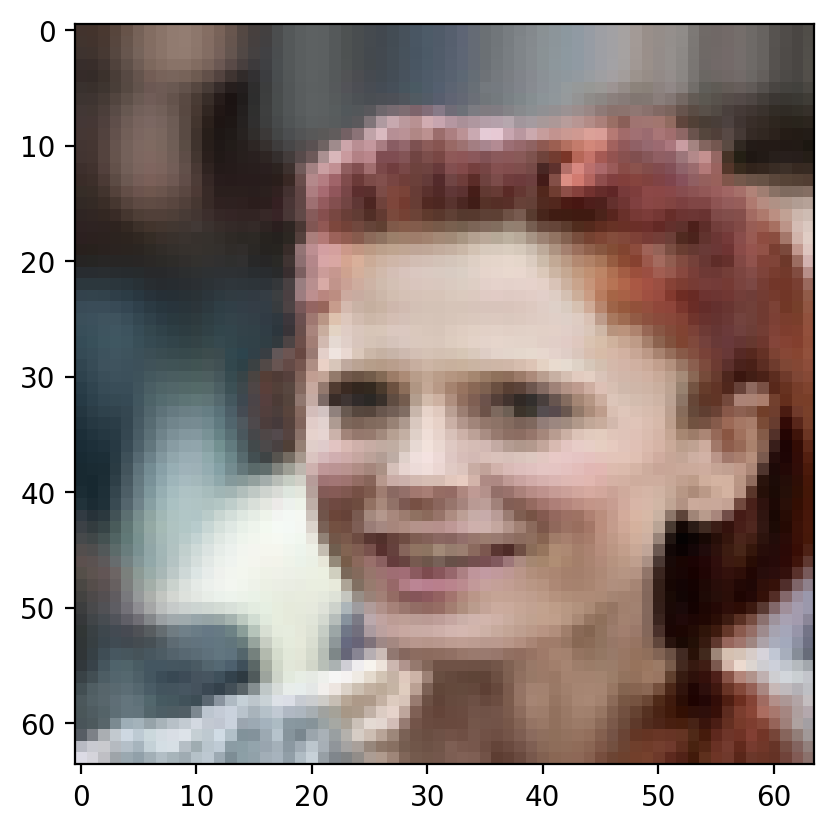

In [132]:
plt.imshow(img0_np_data[0][3].reshape(3,64,64).permute(1,2,0).detach().cpu())

In [167]:
from tqdm import tqdm
data_train_cnp=locc(50)
# for i in tqdm(range(len(data_train_cnp))):
#   a,b,c,d=data_train_cnp[i]
train3(net3,data_train_cnp,n_iter=4000)

Epoch 0 loss: 1.284174
Epoch 100 loss: -0.180639
Epoch 200 loss: -0.317790
Epoch 300 loss: -0.329349
Epoch 400 loss: -0.425184
Epoch 500 loss: -0.552913
Epoch 600 loss: -0.647731
Epoch 700 loss: -0.511358
Epoch 800 loss: -0.628943
Epoch 900 loss: -0.450679
Epoch 1000 loss: -0.767840
Epoch 1100 loss: -0.796792
Epoch 1200 loss: -0.748474
Epoch 1300 loss: -0.840239
Epoch 1400 loss: -0.660959
Epoch 1500 loss: -0.865560
Epoch 1600 loss: -0.864370
Epoch 1700 loss: -0.948376
Epoch 1800 loss: -0.656834
Epoch 1900 loss: -1.020090
Epoch 2000 loss: -1.106929
Epoch 2100 loss: -1.062704
Epoch 2200 loss: -1.151012
Epoch 2300 loss: -1.190693
Epoch 2400 loss: -1.087303
Epoch 2500 loss: -1.047172
Epoch 2600 loss: -1.269031
Epoch 2700 loss: -1.283102
Epoch 2800 loss: -1.156053
Epoch 2900 loss: -0.986610
Epoch 3000 loss: -1.348738
Epoch 3100 loss: -1.092024
Epoch 3200 loss: -1.341507
Epoch 3300 loss: -1.405833
Epoch 3400 loss: -1.261496
Epoch 3500 loss: -1.369518
Epoch 3600 loss: -1.416804
Epoch 3700 los

-1.4720100164413452

In [199]:
arrr=locc(95)

In [200]:
aa,bb,cc,dd=arrr[13]
llmm=net3(aa,bb,cc,dd)

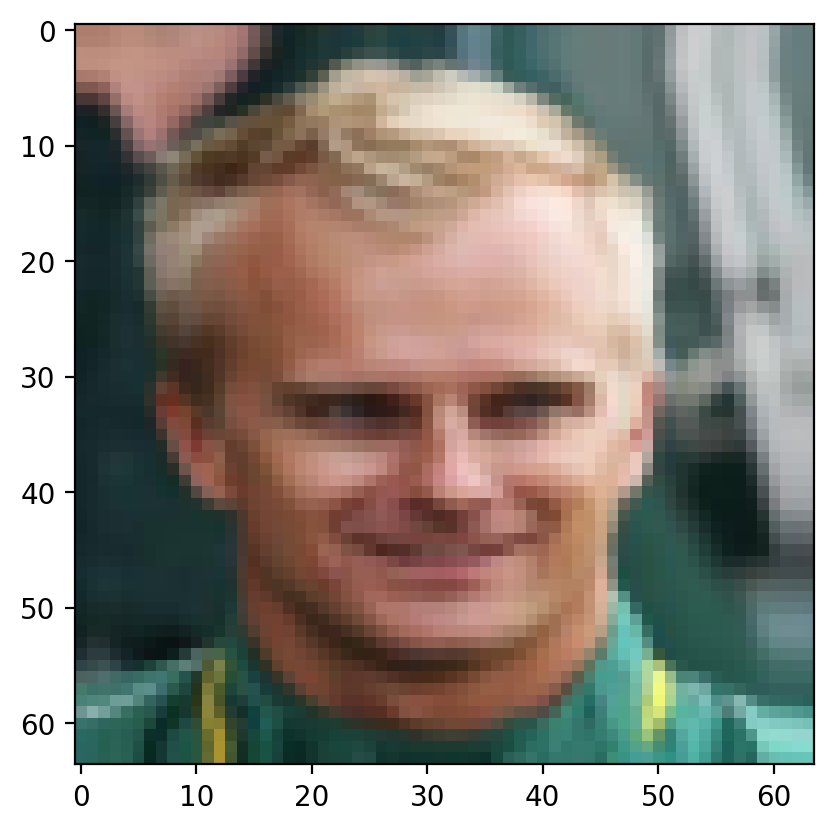

In [201]:
plt.imshow(dd.reshape(3,64,64).permute(1,2,0).detach().cpu())

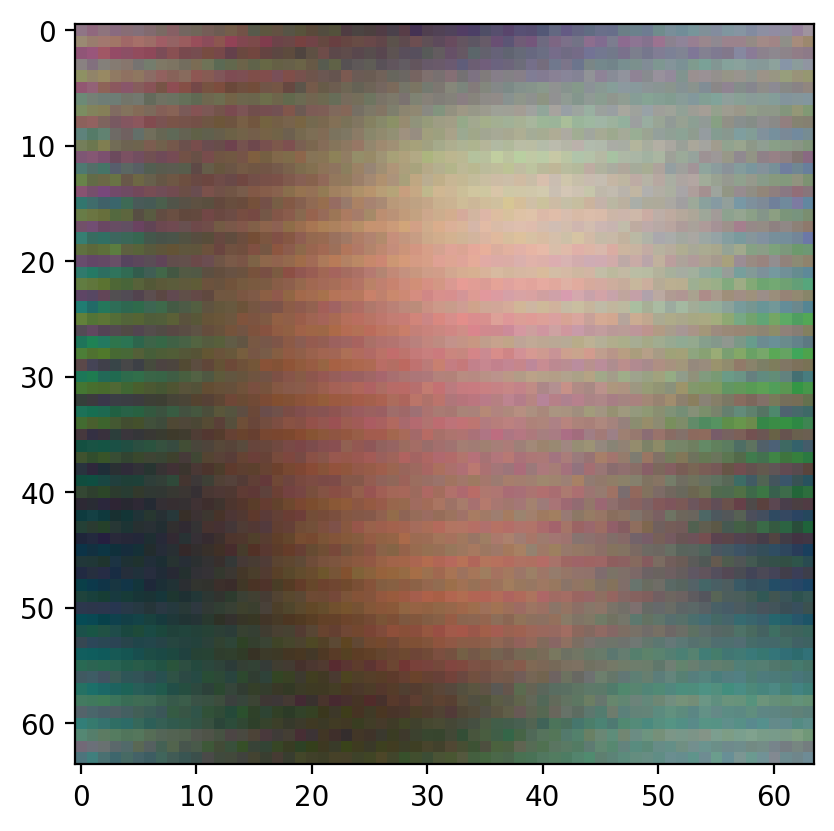

In [202]:
plt.imshow(llmm[0].rsample([100]).mean(dim=0).reshape(3,64,64).permute(1,2,0).detach().cpu())

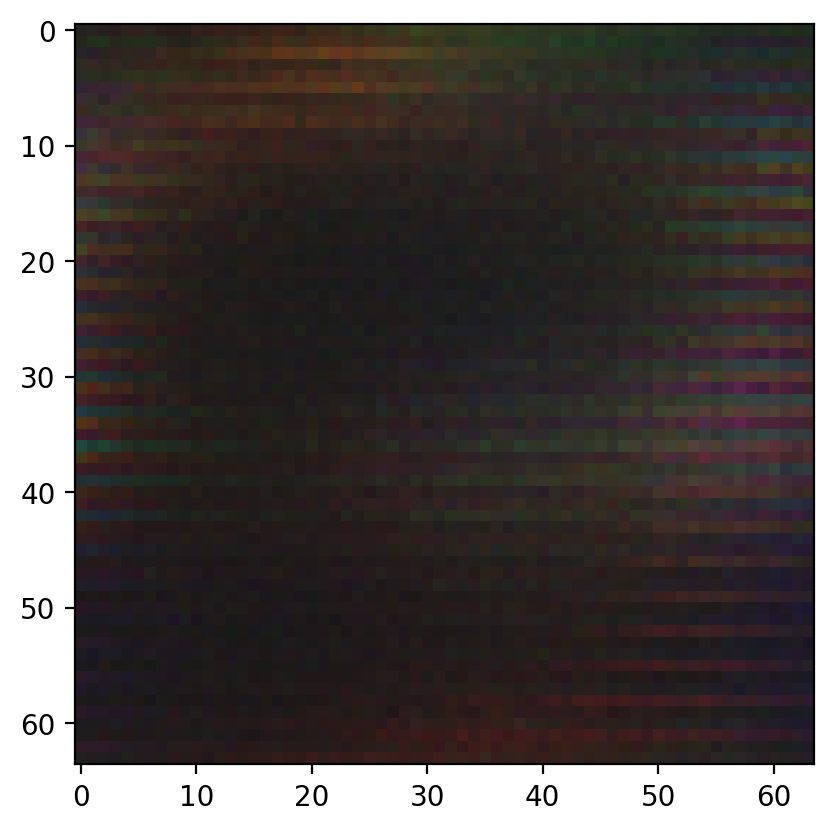

In [197]:
plt.imshow(llmm[0].rsample([100]).std(dim=0).reshape(3,64,64).permute(1,2,0).detach().cpu())